# Implementation of Oregonator Model using Deterministic and Well-Mixed Stochastic Solvers

## Model

The Oregonator model is the simplest realistic model of the nonlinear oscillatory Belousov-Zhabotinsky reaction. It exhibists oscillating phenomena even if the system is far from the thermodynamic equilibrium.   
For this notebook a simplified version of the oscillator is considered, involving 3 species and five reactions.   
More precisely:

\begin{equation}
    R_{1}: X+Y{\overset{c_{1}}{\rightarrow}}\emptyset
\end{equation} 
\begin{equation}
    R_{2}: Y{\overset{c_{2}}{\rightarrow}}X
\end{equation}
\begin{equation}
    R_{3}: THF{\overset{c_{3}}{\rightarrow}}2X+Z
\end{equation}
\begin{equation}
    R_{4}: 2X{\overset{c_{4}}{\rightarrow}}\emptyset
\end{equation}
\begin{equation}
    R_{5}: Z{\overset{c_{5}}{\rightarrow}}Y
\end{equation}    

The mass-action stochastic kinetics are:  
\begin{equation}
    c_{1} = 0.1
\end{equation} 
\begin{equation}
    c_{2} = 2
\end{equation}
\begin{equation}
    c_{3} = 104
\end{equation}
\begin{equation}
    c_{4} = 0.016
\end{equation}
\begin{equation}
    c_{5} = 26
\end{equation}  
The underlying mechanism of the Oregonator is regulated by an autocatalytic reaction (reaction $R_{3}$ ) and a negative feedback loop (via reactions $R_{3}$, $R_{5}$ and $R_{1}$). The products of reaction $R_{3}$ are the activator $X$ and the inhibitor $Z$. The activator $X$ catalyzes back the production of its reaction (hence, the name autocalytic reaction). The inhibitor $Z$ inhibits the autocatalytic production of $X$ through the reaction sequence $R_{3}$ $\rightarrow$ $R_{5}$ $\rightarrow$ $R_{1}$ . The presence of both the activator and inhibitor processes causes a nonlinear behavior leading to the spontaneous generation of oscillations.  
The model description is defined in Appendix A.5 of the textbook [Simulation Algorithms for Computational Systems Biology](https://link.springer.com/content/pdf/10.1007/978-3-319-63113-4.pdf).



## Convert between STEPS kcst ($M^{1-n}s^{-1}$) and population stochastic reaction rate in a given volume ($s^{-1}$)
Imported from *steps_unit_conv.ipynb*

In [1]:
def get_rate_conversion_factor(lhs_molecule_list, volume):
    import numpy as np

    # Avogadro number: molecules in 1 mol
    A = 6.02214076e23
    litres = 1e3 * volume
    # get order of reaction
    order = len(lhs_molecule_list)
    # get factorial factor
    counts = dict()
    factorial_factor = 1
    for lhs in lhs_molecule_list:
        counts[lhs] = counts.get(lhs, 0) + 1
        factorial_factor *= counts[lhs]
    return factorial_factor * np.power(A * litres, 1 - order)


# convert stochastic reaction rate in specified volume to STEPS kcst
def get_kcst(stoch_rate_c, lhs_molecule_list, volume):
    factor = get_rate_conversion_factor(lhs_molecule_list, volume)
    return stoch_rate_c / factor


# convert STEPS kcst to stochastic reaction rate in specified volume
def get_stoch_rate(stoch_rate_kcst, order, volume):
    factor = get_rate_conversion_factor(lhs_molecule_list, volume)
    return stoch_rate_kcst * factor

## Simulation for a single iteration using the Direct Method solver

Simulation Time (sec)
0.027871131896972656


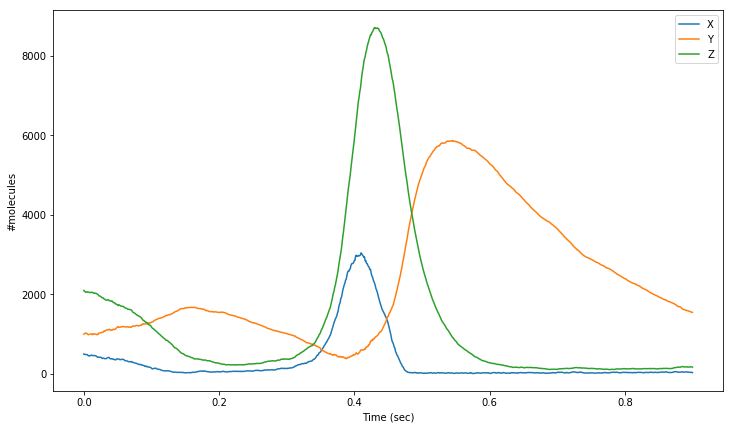

In [2]:
# Importing of time package to measure the simulation time
import time

# Importing numpy 
import numpy

import matplotlib.pyplot as plt
# Importing geometry module
import steps.geom as swm
# Import model container
import steps.model as smodel
# Creation of random number generator needed by Wmdirect Solver
import steps.rng as srng
# Importing solvers package
import steps.solver as ssolver

# Creating the model constructor
mdl = smodel.Model()

# Enumeration of chemical species that can occur in the model.
molX = smodel.Spec('X', mdl)
molY = smodel.Spec('Y', mdl)
molZ = smodel.Spec('Z', mdl)

# Creation of volume system
volsys = smodel.Volsys('vsys', mdl)
vol = 1.6667e-26

# Creation of reaction rules
kreac_1 = smodel.Reac('kreac_1', volsys, lhs=[molX, molY], rhs=[])
kreac_2 = smodel.Reac('kreac_2', volsys, lhs=[molY], rhs=[molX])
kreac_3 = smodel.Reac('kreac_3', volsys, lhs=[molX], rhs=[molX, molX, molZ])
kreac_4 = smodel.Reac('kreac_4', volsys, lhs=[molX, molX], rhs=[])
kreac_5 = smodel.Reac('kreac_5', volsys, lhs=[molZ], rhs=[molY])


# Defining actual compartment
wmgeom = swm.Geom()
comp = swm.Comp('comp', wmgeom)
comp.addVolsys('vsys')
comp.setVol(vol)

# Calculation and Initialization of Reaction Constants
kreac_1.kcst = get_kcst(0.1, ['X','Y'], vol)
kreac_2.kcst = get_kcst(2, ['Y'], vol)
kreac_3.kcst = get_kcst(104, ['X'], vol)
kreac_4.kcst = get_kcst(0.016, ['X','X'], vol)
kreac_5.kcst = get_kcst(26, ['Z'], vol)


# Initialization of random number generator
r = srng.create('mt19937', 256)
r.initialize(23412)


# Creation of Wmdirect solver
sim = ssolver.Wmdirect(mdl, wmgeom, r)

# Calling reset function of the solver
sim.reset()

# Setting concentrations (amount of molecules in this occasion) of the simulation
sim.setCompCount('comp', 'X', 500)
sim.setCompCount('comp', 'Y', 1000)
sim.setCompCount('comp', 'Z', 2100)

# Creating empty arrays to save the simulation results
tpnt = numpy.arange(0.0, 0.901, 0.001)
res = numpy.zeros([901, 3])


start = time.time()

# Actual simulation iterator
for t in range(0,901):
    # Running the Wmdirect Solver for one step
    sim.run(tpnt[t])
    # Saving the results
    res[t,0] = sim.getCompCount('comp', 'X')
    res[t,1] = sim.getCompCount('comp', 'Y')
    res[t,2] = sim.getCompCount('comp', 'Z')
    
# End of simulation and printing of simulation time    
end = time.time()
print("Simulation Time (sec)")
print(end - start)    

# Plotting simulation results (Number of molecules)
%matplotlib inline
plt.figure(figsize=(12,7))
# Plot number of molecules of 'X' over the time range:
plt.plot(tpnt, res[:,0], label = 'X')
# Plot number of molecules of 'Y' over the time range:
plt.plot(tpnt, res[:,1], label = 'Y')
# Plot number of molecules of 'Z' over the time range:
plt.plot(tpnt, res[:,2], label = 'Z')
plt.xlabel('Time (sec)')
plt.ylabel('#molecules')
plt.legend()
plt.show()

## Simulation with the Wmdirect solver for NITER iterations to calculate the average populations

Simulation Time (sec)
5.738232135772705


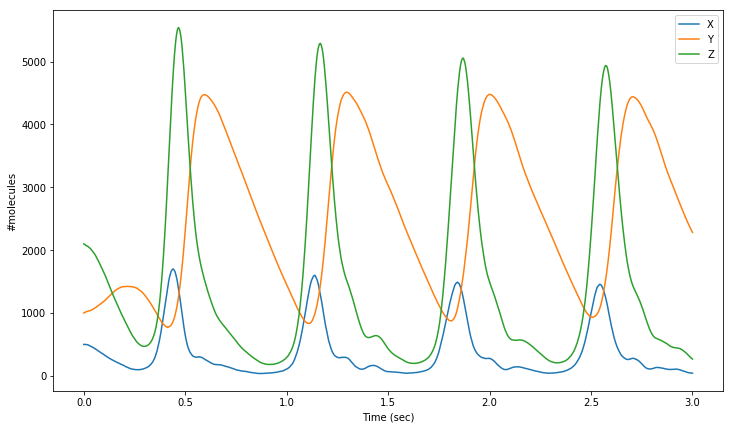

In [3]:
# Running the same simulation for NITER times to calculate the mean of molecule concentrations
NITER = 100
res = numpy.zeros([NITER, 3001, 3])
tpnt = numpy.arange(0.0, 3.001, 0.001)
start = time.time()

# Run the same simulation for NITER times
for i in range(0, NITER):
    sim.reset()
    # Setting concentrations (amount of molecules in this occasion) of the simulation
    sim.setCompCount('comp', 'X', 500)
    sim.setCompCount('comp', 'Y', 1000)
    sim.setCompCount('comp', 'Z', 2100)
    for t in range(0, 3001):
        # Running the Wmdirect Solver for one step and saving the results
        sim.run(tpnt[t])
        res[i,t,0] = sim.getCompCount('comp', 'X')
        res[i,t,1] = sim.getCompCount('comp', 'Y')
        res[i,t,2] = sim.getCompCount('comp', 'Z')

end = time.time()
print("Simulation Time (sec)")
print(end - start) 
# Calculation of mean of concentration
res_mean = numpy.mean(res, 0)

plt.figure(figsize=(12,7))
# Plot number of molecules of 'X' over the time range:
plt.plot(tpnt, res_mean[:,0], label = 'X')
# Plot number of molecules of 'Y' over the time range:
plt.plot(tpnt, res_mean[:,1], label = 'Y')
# Plot number of molecules of 'Z' over the time range:
plt.plot(tpnt, res_mean[:,2], label = 'Z')

plt.xlabel('Time (sec)')
plt.ylabel('#molecules')
plt.legend()

## Benchmarking

Running the same simulation with different solvers to check the performance variation between them.

## Wmrk4
Non-spatial deterministic solver based on the Runge-Kutta forth order method.

In [4]:
# Solver definition
sim_rk4 = ssolver.Wmrk4(mdl, wmgeom)
sim_rk4.setRk4DT(1e-4)

## Wmdirect
Non-spatial stochastic solver based on Gillespie's SSA.

In [5]:
# Initialization of random generator
r_direct = srng.create('mt19937', 256)
r_direct.initialize(23412)
# Solver definition
sim_direct = ssolver.Wmdirect(mdl, wmgeom, r_direct)

## RSSA
Non-spatial stochastic solver based on Gillespie's SSA. 
It is called Reduction-based SSA due to the fact that it aims to reduce the number of propensity updates during the simulation.

In [6]:
# Initialization of random generator
r_RSSA = srng.create('mt19937', 256)
r_RSSA.initialize(23412)
# Solver definition
sim_RSSA = ssolver.Wmrssa(mdl, wmgeom, r_direct)

## Main Simulation
In this part the main simulation will run for the following cases:  

| Run | #X | #Y | #Z |
| --- | ---- | ---- | ---- |
| 1 | 5 | 10 | 20 |
| 2 | 50 | 100 | 200 |
| 3 | 500 | 1000 | 2000 |
| 4 | 5000 | 10000 | 20000 |  
| 5 | 50000 | 100000 | 200000 |  

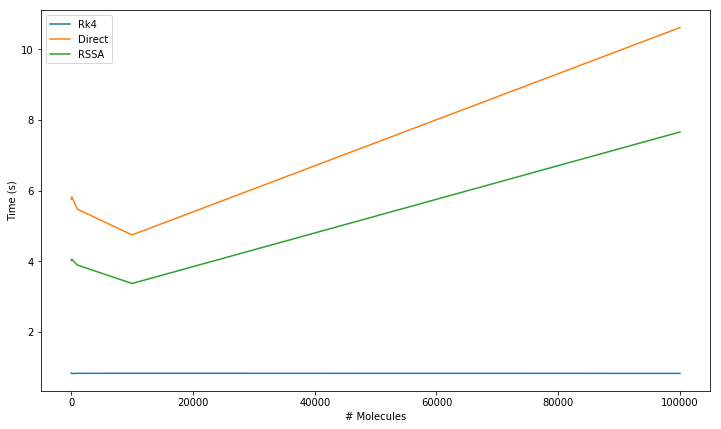

In [7]:
# Running the same simulation for NITER times to calculate the mean of molecule concentrations
import numpy as np

NITER = 100
sim_times = numpy.zeros([3, 5])
tpnt = numpy.arange(0.0, 3.001, 0.001)
simulators = [sim_rk4, sim_direct, sim_RSSA]
plt_ = [1e1, 1e2, 1e3, 1e4, 1e5]

for (i_sim, sim) in enumerate(simulators):
    for j in range(0, 5):
        start = time.time()
        for i in range(0, NITER):
            sim.reset()
            # Setting concentrations (amount of molecules in this occasion) of the simulation
            sim.setCompCount('comp', 'X', 5 * np.power(10, j))
            sim.setCompCount('comp', 'Y', 10 * np.power(10, j))
            sim.setCompCount('comp', 'Z', 20 * np.power(10, j))
            for t in range(0, 3001):
                # Running the Solver for one step
                sim.run(tpnt[t])
        end = time.time()
        sim_times[i_sim, j] = end - start

plt.figure(figsize=(12, 7))
# Plot simulation time of Rk4 solver for the different populations of molecules:
plt.plot(plt_, sim_times[0, :], label='Rk4')
# Plot simulation time of Direct Method solver for the different populations of molecules:
plt.plot(plt_, sim_times[1, :], label='Direct')
# Plot simulation time of RSSA solver for the different populations of molecules:
plt.plot(plt_, sim_times[2, :], label='RSSA')

plt.xlabel('# Molecules')
plt.ylabel('Time (s)')
plt.legend()